In [1]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler



!pip -qq install skorch xgboost

In [2]:
def plot_prediction_vs_truth(y_test, y_pred, model="", title="Prediction vs Truth"):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label="Predictions")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit")
    plt.title(f"{model} {title}")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid()
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")


def plot_residuals(y_test, y_pred, model="", title="Residual Plot"):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.7, color='purple')
    plt.axhline(0, color='red', linestyle='--', label="Zero Error")
    plt.title(f"{model}: {title}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Truth - Prediction)")
    plt.legend()
    plt.grid()
    plt.show()


def plot_predictions_and_truth(y_test, y_pred, x_values=None, model="", title="Prediction vs Truth"):
    plt.figure(figsize=(10, 6))

    if x_values is None:
        x_values = range(len(y_test))

    plt.plot(x_values, y_test, label="True Values", color='blue', marker='o', linestyle='-', alpha=0.7)
    plt.plot(x_values, y_pred, label="Predicted Values", color='orange', marker='x', linestyle='--', alpha=0.7)

    plt.title(f"{model} {title}")
    plt.xlabel("Index or Feature")
    plt.ylabel("Values")
    plt.legend()
    plt.grid()
    plt.show()



# Loading data

In [3]:
df = pd.read_csv("sbern_2_clean_data_PCA.csv")
df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC205,PC206,PC207,PC208,PC209,PC210,PC211,PC212,max_salary,min_salary
0,0.136298,0.202938,0.017407,0.115302,0.061802,0.087451,-0.170609,0.148085,0.093537,-0.101025,...,-0.028307,-0.037816,-0.011891,-0.000947,0.016459,0.000568,-0.016937,-0.015519,41600.0,35360.0
1,-0.342289,-0.013625,0.077035,-0.129389,0.084460,0.255426,-0.077733,0.022046,-0.106214,-0.006364,...,0.001817,0.001787,-0.004595,-0.002496,-0.005328,-0.040614,-0.014279,-0.073297,104000.0,62400.0
2,-0.000155,0.123623,-0.004454,0.242199,-0.134663,0.076023,-0.017161,0.084982,-0.130425,0.086450,...,0.036098,-0.006755,0.005480,-0.037799,0.064363,-0.070935,0.053857,0.032927,65000.0,45000.0
3,-0.109992,0.150033,-0.109075,-0.219562,0.227574,0.206503,-0.122634,0.193660,-0.094541,-0.163855,...,-0.033363,0.022779,0.012962,-0.012287,-0.021904,-0.003897,0.007650,-0.008473,175000.0,140000.0
4,-0.046352,-0.126525,0.084076,0.194379,-0.022354,-0.073512,0.014311,0.017231,-0.139651,-0.173849,...,0.034392,0.016044,0.002199,-0.001654,0.028254,0.010430,0.001652,-0.009032,80000.0,60000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27966,-0.181064,0.020990,-0.101993,-0.234869,0.156127,-0.085843,-0.075127,0.167292,0.223576,-0.102588,...,-0.005127,0.009120,-0.019738,-0.012641,0.006284,-0.025882,0.008950,-0.006024,93600.0,72800.0
27967,-0.062089,0.067091,-0.083694,0.171000,-0.204710,0.128666,-0.024939,0.012573,0.075908,-0.020666,...,-0.002262,-0.007110,-0.035848,0.031286,0.005774,0.012093,0.016351,-0.022072,65000.0,50000.0
27968,-0.066488,-0.264636,0.127959,-0.188287,-0.075430,-0.201351,0.165507,0.169050,0.008531,-0.021482,...,0.012450,-0.009408,0.028308,-0.005317,-0.006128,0.017739,0.026591,-0.012985,104000.0,62400.0
27969,-0.061350,-0.002184,-0.145496,-0.115441,0.160700,0.176814,-0.157668,0.055412,-0.321743,-0.080778,...,-0.039578,-0.006601,-0.009273,0.000350,-0.033172,0.017963,0.001939,0.058830,195000.0,120000.0


In [4]:
X = df.drop(columns=["min_salary", "max_salary"])
y_min = df["min_salary"]
y_max = df["max_salary"]


# # Extract target columns
# y_min = df["min_salary"].values.reshape(-1, 1)
# y_max = df["max_salary"].values.reshape(-1, 1)

# # Initialize scalers
# scaler_min = StandardScaler()
# scaler_max = StandardScaler()

# # Standardize (fit and transform)
# y_min = scaler_min.fit_transform(y_min).ravel()
# y_max = scaler_max.fit_transform(y_max).ravel()


X_train, X_test, y_min_train, y_min_test, y_max_train, y_max_test = train_test_split(
    X, y_min, y_max, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_min_train shape:", y_min_train.shape)
print("y_min_test shape:", y_min_test.shape)
print("y_max_train shape:", y_max_train.shape)
print("y_max_test shape:", y_max_test.shape)

X_train shape: (22376, 212)
X_test shape: (5595, 212)
y_min_train shape: (22376,)
y_min_test shape: (5595,)
y_max_train shape: (22376,)
y_max_test shape: (5595,)


In [5]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model

In [6]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [7]:
from xgboost import XGBRegressor


xgb_model = XGBRegressor(
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,       # Maximum tree depth
    subsample=0.8,     # Subsample ratio
    colsample_bytree=0.8,  # Feature subset ratio
    random_state=42,
    tree_method='gpu_hist',  # Use GPU for training
    predictor='gpu_predictor'  # Use GPU for predictions
)


## Training for predicting min_salary

In [8]:
from skorch import NeuralNetRegressor

In [9]:
param_grid = {
    'n_estimators': [200, 300, 500, 600],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01,0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


In [10]:
xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [11]:
xgb_random.fit(
    X_train.astype('float32'),
    y_min_train.values.astype('float32').reshape(-1, 1)
    )

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=600, subsample=0.8; total time=   7.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=600, subsample=0.8; total time=   7.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=600, subsample=0.8; total time=   7.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  16.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  16.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  16.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.6; total time=  18.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.6; total time=  17.9s
[CV] END colsample_

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [200, 300, 500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [12]:
best_params = xgb_random.best_params_
print("Best Parameters:", best_params)

# Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Best Parameters: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [13]:
best_params['n_estimators'] = 500 

# Retrain the model with extended parameters
extended_xgb = XGBRegressor(**best_params)

## Evaluation for predicting min_salary

In [14]:
extended_xgb.fit(
    X_train.astype('float32'),
    y_min_train.values.astype('float32').reshape(-1, 1)
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
y_min_pred = extended_xgb.predict(X_test.astype('float32'))

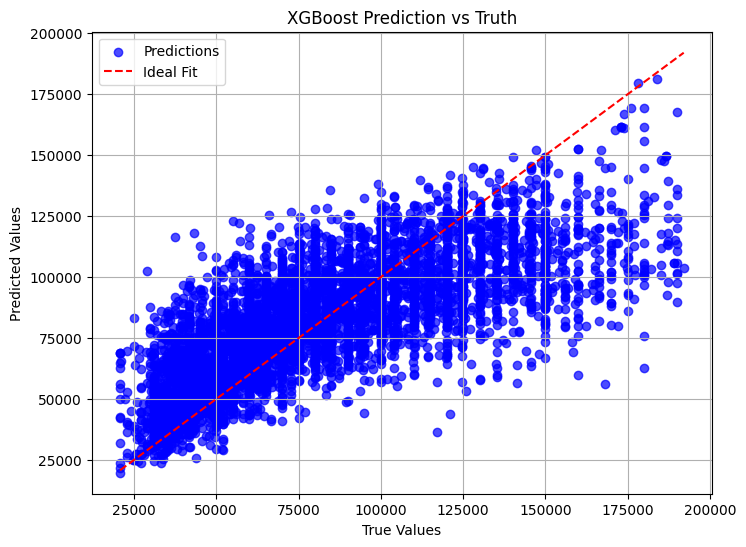

Mean Squared Error: 614160488.20


In [16]:
plot_prediction_vs_truth(y_min_test, y_min_pred, model="XGBoost")
# plot_residuals(y_min_test, y_min_pred, model="MLP")
# plot_predictions_and_truth(y_min_test, y_min_pred, model="MLP")

# Evaluation for predicting max_salary

## SVM plots

In [17]:
# plot_prediction_vs_truth(y_max_test, svr_predictions, model="SVM")
# plot_residuals(y_max_test, svr_predictions, model="SVM")
# plot_predictions_and_truth(y_max_test, svr_predictions, model="SVM")